We fit a gaussian mixture model with a fixed number of clusters; we then estimate for each cluster the kerneldensity and compare it with the kerneldensity at the same point in a randomized dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import glob

import pylab as plt
from matplotlib.pyplot import get_cmap
%matplotlib inline  

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir

from analysis.cluster_density import gmm_kd
from analysis.data_sample import get_subset
from analysis.density import rho_pval,rho_eff

# Load data and setup

In [2]:
# factor scores
path_read = os.path.join(src_dir,os.pardir,'data_filter')
fname_read = 'ipip300-no0_arr_pd_neoac_score-1.npy'
filename = os.path.join(path_read,fname_read)
arr_pd =  np.load(filename)

# parameters for fitting
n_rep = 10 # number of different initial conditions for optimization
Nc = 13 # this is the number we found in the paper
n_rep_kd = 1000 # number of randomizations for estaimting density 
bw = -1 # bandwidth for density estimation (-1, estimate from avg nearest-neighbor distance)
N_samples = 10000 # number of pairs of n.n. for estimating bandwidth 


In [3]:
#####
# z-score the data in each dimension
#####
N_,D_ = np.shape(arr_pd)
for d in range(D_):
    x_tmp = arr_pd[:,d]
    x_mu = np.mean(x_tmp)
    x_std = np.std(x_tmp)
    arr_pd[:,d] = (x_tmp - x_mu)/x_std

#####
# get a random subset to reduce processing time
# use line above if you want to fit the whole dataset
#####
arr_x = 1.0*arr_pd#
# arr_x = get_subset(arr_pd,10000) 


# Fit

In [4]:
## fit the gmm
dict_result = gmm_kd(Nc,arr_x,n_rep,n_rep_kd, bw = bw, N_samples = N_samples)

In [16]:

## the cluster centers
arr_cd = dict_result['cluster']
## the covariance matrix for each cluster
list_arr_cov = dict_result['cov']



arr_rho = dict_result['rho'] ## density for each cluster in original dataset
arr_rho_rand = dict_result['rho_rand'] ## density for each cluster in randomized dataset

## the p-value and the enrichment for the kerneldensity 
## in comparison to kd in randomimzed datat
arr_rho_eff = rho_eff(arr_rho,arr_rho_rand)
arr_rho_pval = rho_pval(arr_rho,arr_rho_rand)

In [17]:
for i_Nc in range(Nc):
    print('Cluster %s '%(i_Nc+1))
    print('N:%.2f | E:%.2f | O:%.2f | A:%.2f | C:%.2f'%
          (arr_cd[i_Nc,0],arr_cd[i_Nc,1],arr_cd[i_Nc,2],arr_cd[i_Nc,3],arr_cd[i_Nc,4]) )
    print('p-value:%.2f | enrichment:%.2f'%
          (arr_rho_pval[i_Nc],arr_rho_eff[i_Nc]))
    print('---')

Cluster 1 
N:0.63 | E:0.19 | O:-0.64 | A:0.35 | C:0.67
p-value:0.00 | enrichment:1.16
---
Cluster 2 
N:-0.87 | E:-1.08 | O:0.32 | A:-0.14 | C:-0.58
p-value:0.97 | enrichment:0.89
---
Cluster 3 
N:0.44 | E:-0.71 | O:0.55 | A:0.93 | C:-0.37
p-value:0.89 | enrichment:0.93
---
Cluster 4 
N:-0.09 | E:0.72 | O:-0.78 | A:-0.65 | C:-0.38
p-value:0.00 | enrichment:1.40
---
Cluster 5 
N:1.10 | E:0.19 | O:0.38 | A:-0.37 | C:-0.74
p-value:0.95 | enrichment:0.91
---
Cluster 6 
N:0.59 | E:-0.83 | O:0.64 | A:-0.16 | C:0.75
p-value:0.81 | enrichment:0.95
---
Cluster 7 
N:0.50 | E:0.90 | O:0.64 | A:0.10 | C:0.35
p-value:0.23 | enrichment:1.04
---
Cluster 8 
N:0.75 | E:-0.93 | O:-0.99 | A:-0.07 | C:-0.53
p-value:0.23 | enrichment:1.06
---
Cluster 9 
N:-0.79 | E:0.35 | O:0.32 | A:0.52 | C:0.72
p-value:0.00 | enrichment:1.46
---
Cluster 10 
N:-0.23 | E:0.45 | O:-0.55 | A:0.42 | C:-0.30
p-value:0.00 | enrichment:1.31
---
Cluster 11 
N:-0.64 | E:0.57 | O:0.82 | A:0.10 | C:-0.66
p-value:1.00 | enrichment:0.8

# Plot the result

for each cluster we plot the p-value and the enrichment

Text(0.5,0,'Enrichment, $\\rho/\\langle \\tilde{\\rho} \\rangle$')

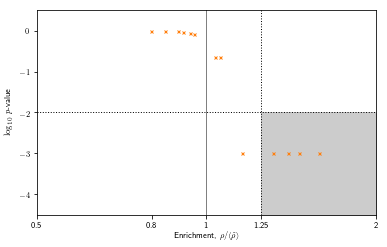

In [18]:
pval_crit = 0.01
eff_crit = 1.25
cmap = get_cmap('tab10')
c_ = cmap(1)
c_shade=str(0.8)
cmap = get_cmap('tab10')


f = plt.figure()

ax = f.add_subplot(111)
x = np.log10(arr_rho_eff + 0.0*np.random.random(size=len(arr_rho_eff))   ) 
y = np.log10(arr_rho_pval)
ax.plot(x,y,ms=3,lw=0,marker='x',color=c_)
# ax.fill_between(x,0.001+0.0*x,1.0+0.0*x,where=y<=pval_crit,color=c_shade)
# ax.set_yscale('log')

#     xmin = 0.
xmax = np.log10(2.)
xmin=-xmax

ymin = -4.5
ymax=0.5
x = np.linspace(xmin,xmax,10)
y = np.log10(pval_crit)+0.0*x
ax.plot(x,y,ms=0,lw=1,ls=':',marker='o',color='black')

x = [np.log10(eff_crit),np.log10(eff_crit)]
y = [ymin,ymax]
ax.plot(x,y,ms=0,lw=1,ls=':',marker='o',color='black')

x = [0,0]
y = [ymin,ymax]
ax.plot(x,y,ms=0,lw=1,ls='-',marker='o',color=str(0.5))#,alpha=0.5)

x = np.linspace(np.log10(eff_crit),xmax,10)
y1 = ymin + 0.0*x
y2 = np.log10(pval_crit) + 0.0*x
ax.fill_between(x,y1,y2,color=c_shade)

# # ax.set_xlabel(r'cluster index')
ax.set_ylabel(r'$\log_{10}$ $p$-value')
# ax.set_yscale('log')

x_marks = np.log10( np.array([0.5,0.8, 1., 1.25,2.]) )
x_labels = ['0.5','0.8','1','1.25','2']
ax.set_xticks(x_marks)
ax.set_xticklabels(x_labels)
# ax.set_xticklabels([])
ax.set_yticks([-4,-3,-2,-1,0])
# ax.set_yticklabels([r'$-3$',r'$-2$',r'$-1$',r'$0$'])
ax.set_ylim(-4.5,0.5)
ax.set_xlim(xmin,xmax)



#     ax.locator_params(axis = 'x',nbins=5)
ax.set_xlabel(r'Enrichment, $\rho/\langle \tilde{\rho} \rangle$',labelpad=3)


# Plot the location of the 4 significant clusters

In [19]:
## sort clusters according to enrichment
ind_sort = np.argsort(arr_rho_eff)[::-1]

arr_rho_eff = arr_rho_eff[ind_sort]
arr_rho_pval = arr_rho_pval[ind_sort]
arr_cd = arr_cd[ind_sort]
list_arr_cov = list_arr_cov[ind_sort]

In [34]:
## coordinates extracted from previus literature

## resilient
x1 = np.array([
        [-0.4,0.25,0.25,0.25,0.4],
        [-0.6,0.45,0.2,0.3,0.5],
        [-0.5,0.25,0.6,0.6,0.6],
        [-0.1,0.4,0.35,0.3,0.5],
        [-0.85,0.5,0.0,0.9,0.7],
        [-0.9,0.8,0.6,0.7,1.0]
               ])
## overcontrolled
x2 = np.array([
        [1.2,-1.2,-0.4,0.4,-0.35],
        [0.6,-0.9,-0.25,0.0,0.0],
        [0.5,-0.6,-1.0,-0.65,-0.1],
        [0.2,-0.9,-0.9,0.0,.1],
        [1.0,0.0,0.8,0.2,0.0],
        [1.3,-1.2,-0.4,-0.8,0.0],
               ])
## undercontrolled
x3 = np.array([
        [0.7,0.0,-0.5,-1.2,-1.2],
        [0.3,0.1,-0.1,-0.45,-0.9],
        [0.15,0.2,0.15,-0.25,-0.75],
        [0.1,-0.2,-0.2,-0.7,-1.2],
        [1.2,-0.75,0.0,-1.2,-1.0],
        [0.8,0.6,0.8,-1.2,0.0]
    ])
## ordinary/
x4 = np.array([
        [np.nan,np.nan,np.nan,np.nan,np.nan],
        [np.nan,np.nan,np.nan,np.nan,np.nan],
        [np.nan,np.nan,np.nan,np.nan,np.nan],
        [np.nan,np.nan,np.nan,np.nan,np.nan],
        [np.nan,np.nan,np.nan,np.nan,np.nan],
        [np.nan,np.nan,np.nan,np.nan,np.nan]
    ])
list_x = [x4,x3,x2,x1]


list_N = np.array([300,1610,735,14718,8315,1644])
list_N_ = np.sqrt(list_N)
# list_ms = np.log(list_N)/np.log(max(list_N))
list_ms =  0.5 + (list_N_/max(list_N_) - min(list_N_)/max(list_N_)   )#*np.sqrt(   min(list_N)/max(list_N)   ) +  np.sqrt(   list_N/max(list_N)   )
list_markers = ['o','X','P','s','D','p']


In [21]:
arr_rho_eff

array([1.58507883, 1.45897958, 1.39530252, 1.31057764, 1.1578193 ,
       1.05504255, 1.03730296, 0.94962593, 0.93452306, 0.90946033,
       0.89126009, 0.84375777, 0.79794677])

In [22]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 400  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.0 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
Ampl = 1.0 # Amplification factor for screen: set this to ONE for final plot of eps
fig_size = [Ampl*fig_width,Ampl*fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.labelsize': Ampl*8,
          'text.fontsize': Ampl*8,
          'legend.fontsize': Ampl*8,
          'xtick.labelsize': Ampl*8,
          'ytick.labelsize': Ampl*8,
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          #'figtext.fontsize': Ampl*10,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          'xtick.direction':'out',
          'ytick.direction':'out'
         }
plt.rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  mplDeprecation)


In [32]:
n_sel = 4
n_std = 1

x_bottom = 0.2
x_left = 0.2
x_right = 0.95
x_top = 0.95
x_h=0.1
x_w=0.05
ms = 7
h = 0.1
cmap = get_cmap('tab10')

list_doms = ['N','E','O','A','C']
list_doms_labels = ['Neuroticism','Extraversion','Openness','Agreeableness','Conscientiousness']
c_names = ['Average','Self-centered','Reserved','Role model']


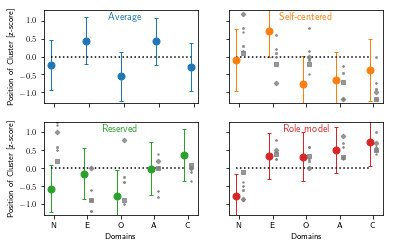

In [35]:
f = plt.figure(figsize=fig_size)
plt.clf()

list_inds = [3,2,0,1 ] ## different ordering of the clusters

for i_plot in range(n_sel):

    ax = f.add_subplot(2,2,i_plot+1)


    i_n = list_inds[i_plot]
    x_vec = arr_cd[i_n,:]
    x_cov_dim_dim = list_arr_cov[i_n]

    x = np.arange(len(list_doms))
    y = x_vec

    yerr = n_std*np.sqrt( x_cov_dim_dim.diagonal()  )
    y1 = y - yerr
    y2 = y + yerr
    
    xshift =  0.0 #-h#(i_n-(n_sel-1)/2.0)*h/((n_sel-1)/2.0)
    c_ = cmap(i_plot)
    ax.errorbar(x+xshift,y,yerr=yerr,label='Cluster %s'%(i_n+1),mec=c_,color=c_,ecolor=c_,mew=1,\
                lw=0,elinewidth=1,marker='o',capsize=2,ms=ms)
    

    ax.plot(x,0.0*x,ls=':',color='black')

    # the labels of the types [ordering of clusters could vary]
    ax.text(2.1, 1.1, c_names[i_plot], rotation=0., color=c_, size=10,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec='white',
                       fc='white',
                       alpha=0.
                       )
             )

    ### the old-literature plots [not supplied here]
    arr_x = list_x[i_plot]
    for i_x_vec,x_vec in enumerate(arr_x):

        x = np.arange(len(list_doms)) +h
        y = x_vec

        xshift = h#(i_n-(n_sel-1)/2.0)*h/((n_sel-1)/2.0)
        c_ = str(0.5)
        ax.plot(x+xshift,y,color=c_,\
                lw=0,marker=list_markers[i_x_vec],ms=3*list_ms[i_x_vec],alpha=0.8)
    
    
    
    ax.set_xticks(x)
    list_y = np.array([-1.0,-0.5,0.0,0.5,1.0])
    ax.set_yticks(list_y)
    if i_plot>1:
        ax.set_xlabel('Domains')
        ax.set_xticklabels(list_doms)
#         ax.set_xticklabels(list_doms_labels, rotation=-30,ha='left')

    else:
        ax.set_xticklabels(['' for j in x])
    if i_plot%2==0:
        ax.set_ylabel(r'Position of Cluster [z-score]')
    else:
        ax.set_yticklabels(['' for j in list_y])
        
        
    # plt.xscale('log')
    # ax.set_yscale('log')
    ax.set_ylim(-1.3,1.3)
    # ax.set_xlim(0,3)